In [1]:
import numpy as np
import torch
print(torch.__version__)

1.6.0+cu101


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
import numpy as np
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split
from glob import glob

def load_notmnist(path='./notMNIST_small',letters='ABCDEFGHIJ',
                  img_shape=(28,28),test_size=0.25,one_hot=False):
    
    # download data if it's missing. If you have any problems, go to the urls and load it manually.
    if not os.path.exists(path):
        if not os.path.exists('./notMNIST_small.tar.gz'):
            print("Downloading data...")
            assert os.system('curl http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz > notMNIST_small.tar.gz') == 0
        print("Extracting ...")
        assert os.system('tar -zxvf notMNIST_small.tar.gz > untar_notmnist.log') == 0
    
    data,labels = [],[]
    print("Parsing...")
    for img_path in glob(os.path.join(path,'*/*')):
        class_i = img_path.split(os.sep)[-2]
        if class_i not in letters: continue
        try:
            data.append(imread(img_path))
            labels.append(class_i,)
        except:
            print("found broken img: %s [it's ok if <10 images are broken]" % img_path)
        
    data = np.stack(data)[:,None].astype('float32')
    data = (data - np.mean(data)) / np.std(data)

    #convert classes to ints
    letter_to_i = {l:i for i,l in enumerate(letters)}
    labels = np.array(list(map(letter_to_i.get, labels)))
    
    if one_hot:
        labels = (np.arange(np.max(labels) + 1)[None,:] == labels[:, None]).astype('float32')
    
    #split into train/test
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=42)
    
    print("Done")
    return X_train, y_train, X_test, y_test

# High-level pytorch

So far we've been dealing with low-level torch API. While it's absolutely vital for any custom losses or layers, building large neura nets in it is a bit clumsy.

Luckily, there's also a high-level torch interface with a pre-defined layers, activations and training algorithms. 

We'll cover them as we go through a simple image recognition problem: classifying letters into __"A"__ vs __"B"__.


In [4]:
X_train, y_train, X_test, y_test = load_notmnist(letters='AB')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

print("Train size = %i, test_size = %i"%(len(X_train),len(X_test)))

Extracting ...
Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done
Train size = 2808, test_size = 937


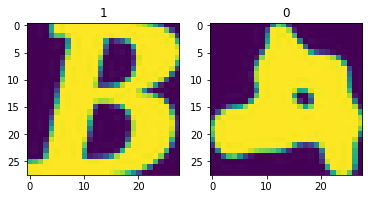

In [6]:
for i in [0,1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(X_train[i].reshape([28,28]))
    plt.title(str(y_train[i]))

Let's start with layers. The main abstraction here is __`torch.nn.Module`__

In [7]:
from torch import nn
import torch.nn.functional as F

print(nn.Module.__doc__)

Base class for all neural network modules.

    Your models should also subclass this class.

    Modules can also contain other Modules, allowing to nest them in
    a tree structure. You can assign the submodules as regular attributes::

        import torch.nn as nn
        import torch.nn.functional as F

        class Model(nn.Module):
            def __init__(self):
                super(Model, self).__init__()
                self.conv1 = nn.Conv2d(1, 20, 5)
                self.conv2 = nn.Conv2d(20, 20, 5)

            def forward(self, x):
                x = F.relu(self.conv1(x))
                return F.relu(self.conv2(x))

    Submodules assigned in this way will be registered, and will have their
    parameters converted too when you call :meth:`to`, etc.
    


There's a vast library of popular layers and architectures already built for ya'.

This is a binary classification problem, so we'll train a __Logistic Regression with sigmoid__.
$$P(y_i | X_i) = \sigma(W \cdot X_i + b) ={ 1 \over {1+e^{- [W \cdot X_i + b]}} }$$


In [8]:
# create a network that stacks layers on top of each other
model = nn.Sequential()

# add first "dense" layer with 784 input units and 1 output unit. 
model.add_module('l1', nn.Linear(784, 1))

# add softmax activation for probabilities. Normalize over axis 1
# note: layer names must be unique
model.add_module('l2', nn.Sigmoid())

In [9]:
print("Weight shapes:", [w.shape for w in model.parameters()])

Weight shapes: [torch.Size([1, 784]), torch.Size([1])]


In [22]:
#  выведите обучаемые параметры
# ваш код здесь

In [10]:
# create dummy data with 3 samples and 784 features

# ваш код здесь

# compute outputs given inputs, both are variables

# ваш код здесь

# display what we've got
# ваш код здесь

tensor([0.7171, 0.4256, 0.5188], grad_fn=<SelectBackward>)

Let's now define a loss function for our model.

The natural choice is to use binary crossentropy (aka logloss, negative llh):
$$ L = {1 \over N} \underset{X_i,y_i} \sum - [  y_i \cdot log P(y_i | X_i) + (1-y_i) \cdot log (1-P(y_i | X_i)) ]$$



In [11]:
crossentropy = # ваш код здесь

loss = # ваш код здесь

assert tuple(crossentropy.size()) == (3,), "Crossentropy must be a vector with element per sample"
assert tuple(loss.size()) == (1,), "Loss must be scalar. Did you forget the mean/sum?"
assert crossentropy.data.numpy()[0] > 0, "Crossentropy must non-negative, zero only for perfect prediction"
assert loss.data.numpy()[0] <= np.log(3), "Loss is too large even for untrained model. Please double-check it."

__Note:__ you can also find many such functions in `torch.nn.functional`, just type __`F.<tab>`__.

__Torch optimizers__

When we trained Linear Regression above, we had to manually .zero_() gradients on both our variables. Imagine that code for a 50-layer network.

Again, to keep it from getting dirty, there's `torch.optim` module with pre-implemented algorithms:

In [12]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

# here's how it's used:
loss.backward()      # add new gradients
opt.step()           # change weights
opt.zero_grad()      # clear gradients

In [14]:
# dispose of old variables to avoid bugs later
del x, y, y_predicted, loss

NameError: ignored

### Putting it all together

In [15]:
# create network again just in case
model = nn.Sequential()
model.add_module('first', nn.Linear(784, 1))
model.add_module('second', nn.Sigmoid())

opt = torch.optim.SGD(model.parameters(), lr=1e-3)

In [16]:
history = []

for i in range(100):
    
    # sample 256 random images
    # ваш код здесь
    
    # predict probabilities
    # ваш код здесь
    
    assert y_predicted.dim() == 1, "did you forget to select first column with [:, 0]"
    
    # compute loss, just like before
    loss = # ваш код здесь
    
    # compute gradients
    # ваш код здесь
    
    # Adam step
    # ваш код здесь
    
    # clear gradients
    # ваш код здесь
    
    history.append(loss.data.numpy())
    
    if i % 10 == 0:
        print("step #%i | mean loss = %.3f" % (i, np.mean(history[-10:])))

step #0 | mean loss = 0.539
step #10 | mean loss = 0.320
step #20 | mean loss = 0.212
step #30 | mean loss = 0.145
step #40 | mean loss = 0.136
step #50 | mean loss = 0.128
step #60 | mean loss = 0.112
step #70 | mean loss = 0.108
step #80 | mean loss = 0.103
step #90 | mean loss = 0.104


__Debugging tips:__
* make sure your model predicts probabilities correctly. Just print them and see what's inside.
* don't forget _minus_ sign in the loss function! It's a mistake 99% ppl do at some point.
* make sure you zero-out gradients after each step. Srsly:)
* In general, pytorch's error messages are quite helpful, read 'em before you google 'em.
* if you see nan/inf, print what happens at each iteration to find our where exactly it occurs.
  * If loss goes down and then turns nan midway through, try smaller learning rate. (Our current loss formula is unstable).


### Evaluation

Let's see how our model performs on test data

In [17]:
# use your model to predict classes (0 or 1) for all test samples
predicted_y_test = # ваш код здесь
predicted_y_test = # ваш код здесь
         
assert isinstance(predicted_y_test, np.ndarray), "please return np array, not %s" % type(predicted_y_test)
assert predicted_y_test.shape == y_test.shape, "please predict one class for each test sample"
assert np.in1d(predicted_y_test, y_test).all(), "please predict class indexes"

accuracy = # ваш код здесь

print("Test accuracy: %.5f" % accuracy)
assert accuracy > 0.95, "try training longer"

print('Great job!')

Test accuracy: 0.96265
Great job!



### More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)